# Estimating lost production from inverter downtime

Inverter downtime is the biggest source of controllable production loss in utility scale solar<sup>[<b><i>citation needed</i></b>]</sup>.  As such, it has a large effect on operational finances and should be understood quantitatively to improve accuracy of pro forma models as well as inform O&M decisions.  

Calculating loss when availability is not 100% is complicated because non-producing inverters often drop communication but non-communicating inverters aren't necessarily non-producing.  This means that a method of detecting inverter production outages and estimating lost production must be able to distinguish non-producing inverters from producing but non-communicating inverters, as well as estimate losses in the face of different inverter sizing, variable weather conditions, and other conditions like array soiling.

Here's a few qualitative requirements for an availability loss routine:

- An outage of a smaller-sized inverter should be associated with a smaller production loss than an outage of a larger-sized inverter.  
- An outage during poor conditions (low light, heavy soiling etc) should be associated with a smaller production loss than one during good conditions -- i.e. availability is based on lost energy rather than outage length. 
- (Actual power + lost power) should be as close as possible to what the system would have produced if all inverters were producing.
- Inverter communications outages should not be associated with production loss, unless the inverter lost comms because it was offline and not producing.

The method presented here is broken into two steps.  The first focuses on individual inverter data streams and attemps to infer each inverter's status (producing or non-producing) for each timestamp.  The second builds on the first and focuses on the system in aggregate to determine timeseries production loss at the system level.  

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')

import rdtools
print(rdtools.__version__)
print(rdtools.__file__)
import pandas as pd
import numpy as np
import pvlib

from rdtools import losses

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)


1.2.0+178.g3a83336.dirty
..\rdtools\__init__.py


## Create some test data

Text(0, 0.5, 'Meter AC Power')

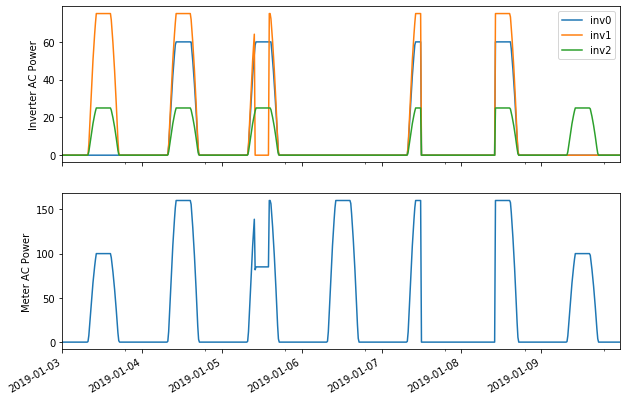

In [3]:
# make up some test clear-sky irradiance and power data
st = '2019-01-03 00:00'
ed = '2019-01-10 00:00'
kWdc = 100.0
gamma = -0.004
lat, lon = 40, -80
tilt = 20
azi = 180
idx = pd.date_range(st, ed, freq='15T', closed='left', tz='US/Eastern')
location = pvlib.location.Location(lat, lon)
solpos = location.get_solarposition(idx)
clearsky = location.get_clearsky(idx, solar_position=solpos)
poa = pvlib.irradiance.get_total_irradiance(tilt,
                                            azi,
                                            solpos['zenith'],
                                            solpos['azimuth'],
                                            clearsky['dni'],
                                            clearsky['ghi'],
                                            clearsky['dhi'])
poa = poa['poa_global']
is_daylight = solpos['elevation'] > 0
tamb = pd.Series(index=idx, data=25)
tcell = pvlib.pvsystem.sapm_celltemp(poa, 0, tamb)
tcell = tcell['temp_cell']

power = poa/1000 * (1 + gamma*(tcell - 25))
inverter_power = pd.DataFrame({
    'inv0': (125.0 * power).clip(upper=60), 
    'inv1': (150.0 * power).clip(upper=75),
    'inv2': (50.0 * power).clip(upper=25)
})

n_inv = 3

expected_power = inverter_power.sum(axis=1)
production_profile = losses.signal_to_profile(expected_power)

# real downtime
inverter_power.loc['2019-01-03', 'inv0'] = 0
inverter_power.loc['2019-01-05 10:00' : '2019-01-05 14:00', 'inv1'] = 0
inverter_power.loc['2019-01-07 12:00' : '2019-01-08 10:00', :] = 0
inverter_power.loc['2019-01-09', 'inv0'] = 0

# record meter now, before inverter comms outages
meter = inverter_power.sum(axis=1)

# all inverters online but not communicating
inverter_power.loc['2019-01-06'] = 0

# mixed downtime and comms
inverter_power.loc['2019-01-09', 'inv1'] = 0

fig, ax = plt.subplots(2,1,sharex=True)

inverter_power.plot(ax=ax[0])
ax[0].set_ylabel('Inverter AC Power')
meter.plot(ax=ax[1])
ax[1].set_ylabel('Meter AC Power')

This toy dataset has several test scenarios:

- Jan 3: one inverter not producing
- Jan 4: all inverters producing
- Jan 5: one inverter not producing for part of the day
- Jan 6: all inverters producing, but none communicating
- Jan 7: no inverters producing after noon
- Jan 8: no inverters producing before 10 AM
- Jan 9: two inverters producing, but only one communicating

## Individual Inverter State

The core of this method is designed to be robust to inverter communications outages.  It works by comparing inverter power data against meter power data.  The meter data acts as an external reference, allowing us to determine if inverters reporting no production are truly offline (meter power agrees with summed inverter power) or producing but not communicating (meter power reads higher than summed inverter power). 

The first step is to set power thresholds that the inverter power must exceed to be considered "producing".  To be consistent for systems with differently-sized inverters, this threshold must be determined separately for each inverter.  It is calculated as 0.01 times the 99th percentile of the inverter's power data.  Using the 99th percentile instead of the maximum makes the method more robust to data issues like transient nonphysical spikes in the readings.  Using a small but nonzero threshold makes the method more robust to tiny positive readings reporting by some inverters when they are not producing.  From here on, an inverter is considered "producing and communicating" if `power > threshold`.

In [4]:
low_limit = 0.01 * inverter_power.quantile(0.99)
low_limit

inv0    0.60
inv1    0.75
inv2    0.25
Name: 0.99, dtype: float64

To determine if any inverters are offline, a virtual "mean inverter" is constructed.  The mean inverter's timeseries production is equal to the mean of all the inverters' power readings, if they had all been online.  This is constructed in two steps:  first, the mean of any producing and communicating inverter powers is calculated.  This value will be biased in cases where the inverters are differently sized and some inverters are not producing or non-communicative.  To remove this bias, the relative capacity of each inverter is calculated by dividing each inverter's power data by the biased mean inverter power and the median is taken for each inverter.  This gives a ratio for each inverter that relates its production capacity against the system mean.  Then, the mean inverter power is calculated again (still using only producing and communicating inverters), but dividing each inverter's power data by its derived relative capacity before taking the mean across inverters.

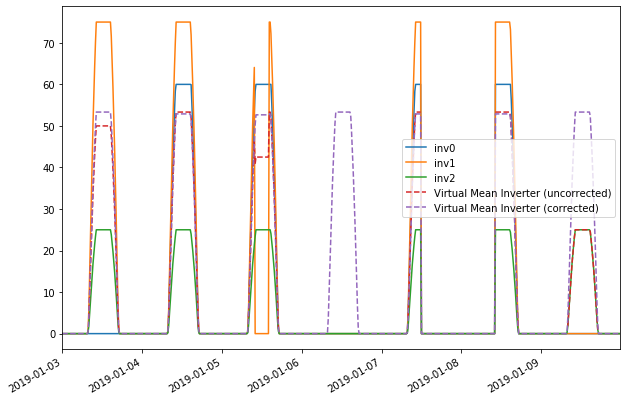

In [5]:
biased_mean_inverter_power = inverter_power[inverter_power > low_limit].mean(axis=1)

# apply correction for relative sizing based on who's reporting
relative_sizing = inverter_power[inverter_power > low_limit] \
                                .divide(biased_mean_inverter_power, axis=0) \
                                .median()
mean_inverter_power = inverter_power[inverter_power > low_limit] \
                                    .divide(relative_sizing, axis=1) \
                                    .mean(axis=1)

# if no inverters appear online, can't determine mean inverter power
all_inverters_appear_offline = (inverter_power < low_limit).all(axis=1)
mean_inverter_power[all_inverters_appear_offline] = meter / n_inv

inverter_power.plot()
biased_mean_inverter_power.plot(label='Virtual Mean Inverter (uncorrected)', ls='--')
mean_inverter_power.plot(label='Virtual Mean Inverter (corrected)', ls='--')
plt.legend()

The above plot shows how the raw mean power is biased by downtime while the capacity-corrected virtual inverter power remains consistent across the different outage scenarios (except when all inverters are offline).  

The virtual inverter is then used to estimate what the meter would read if all inverters were online and producing.  Because the virtual inverter provides an outage-independent estimate of the mean inverter power for each timestamp, simply multiplying it by the number of inverters gives an estimate for system-level production with no capacity losses.  When all inverters are producing (even if some are not reporting), this estimate should line up with meter power.  Here is a plot of the percent difference between meter power and the virtual system power:

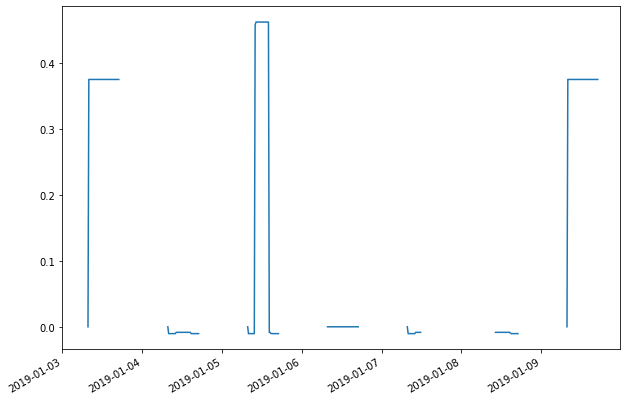

In [6]:
meter_delta = 1 - meter / (n_inv * mean_inverter_power)
meter_delta.plot()

This shows large differences when one or more inverters is offline and small differences when all inverters are producing.  The case of total system downtime doesn't show up because meter power is zero.  To determine whether or not the percent difference is large enough to signal downtime, we determine the expected discrepancy if the smallest inverter that does not look like it is producing (as determined by the threshold test) were actually offline:

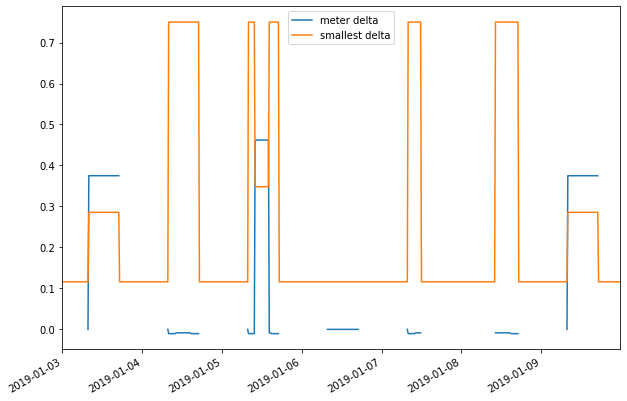

In [7]:
inverter_fraction = relative_sizing / relative_sizing.sum()
smallest_delta = (inverter_power.le(low_limit)  
                                .replace(False, np.nan)  # only consider inverters that look like they're not producing -- nan is ignored later on
                                .multiply(inverter_fraction)  # weight by each inverter's system capacity fraction 
                                .min(axis=1)  # pick the smallest one, to be conservative
                                .fillna(1))  # if nothing, use safe value of 100%
meter_appears_low = meter_delta > (0.75 * smallest_delta) # compare against 0.75 to allow some noise in the readings

meter_delta.plot(label='meter delta')
(0.75 * smallest_delta).plot(label='smallest delta')
plt.legend()

At this point we are able to detect times when some (but not all) inverters are truly offline.  If the difference between virtual system power and meter power is larger than the smallest possible difference AND some inverters actually look offline based on the threshold test, then we'll say some inverters are non-producing.  Determining which inverters aren't producing is not always possible -- take the case where one inverter is non-producing and another is just non-communicative.  The virtual power vs meter power comparison will tell you an inverter is offline, but how do you know which one?  To be conservative, we flag all inverters that could be non-producing.

In [8]:
inverters_appear_offline = (inverter_power < low_limit).any(axis=1)
inverters_offline = inverters_appear_offline & meter_appears_low

# assume that if at least 1 inv is offline then any inv below threshold is
# offline.  this will overcount if some invs are online but not reporting.
online_mask = pd.DataFrame(index=inverter_power.index,
                           columns=inverter_power.columns,
                           data=True)
online_mask.loc[inverters_offline, :] = inverter_power.gt(low_limit)

The last step is handle the special case where all inverters are offline and the above virtual power machinery fails.

In [9]:
# if both meter and inverters look offline, we'll say it's offline
meter_appears_offline = meter < np.sum(low_limit)
site_offline = all_inverters_appear_offline & meter_appears_offline
online_mask.loc[site_offline, :] = False

Finally, let's visualize the results.  The final heatmap shows the status for each inverter (yellow=producing). 

Text(0, 0.5, 'Inverter Status')

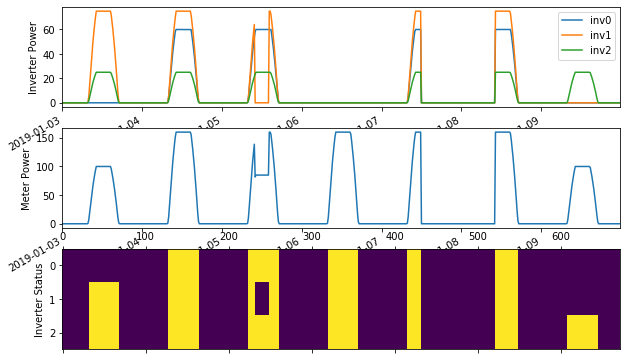

In [10]:
fig, ax = plt.subplots(3, 1)
inverter_power.plot(ax=ax[0])
ax[0].set_ylabel('Inverter Power')

meter.plot(ax=ax[1])
ax[1].set_ylabel('Meter Power')

plt.sca(ax[2])
plt.matshow(online_mask.T, aspect='auto', fignum=0)
ax[2].set_ylabel('Inverter Status')

## Estimating Production Loss

The second part of the method is to estimate timeseries production loss at the system level.  This is done by determining what fraction of system capacity is online and producing and using that to scale meter production.  

First, we need to determine the fraction of online system capacity.  This is done using the `online_mask` array from part 1 and the relative inverter sizing:

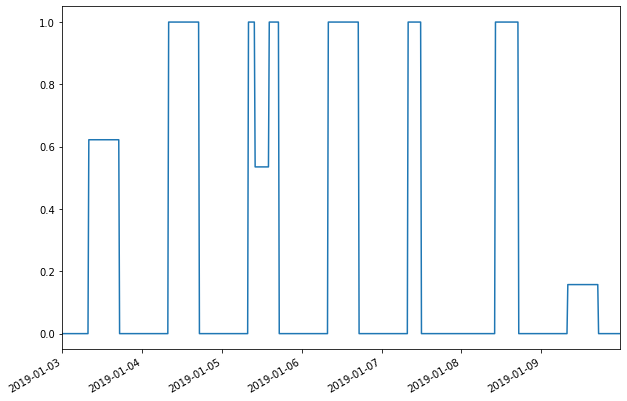

In [11]:
# inverter-specific fraction of total production
inverter_shares = inverter_power[online_mask].div(meter, axis=0).median()
inverter_shares /= inverter_shares.sum()  # normalize it so sum == 1

# timeseries fraction of online site capacity
online_fraction = online_mask.multiply(inverter_shares, axis=1).sum(axis=1)
online_fraction.plot()

However, as noted above, `online_mask` can sometimes flag too many inverters in cases of mixed downtime and communications outage.  Therefore we have to correct `online_fraction` accordingly.  The ratio of summed inverter power to meter power represents the fraction of producing capacity that is communicating. 

In [12]:
inv_sum = inverter_power.sum(axis=1)
communications_factor = (meter / inv_sum).clip(lower=1)
# if no invs are reporting power, can't calculate this comms ratio.
# it could be either total system production outage or just bad comms
# issues outage.  either way it doesn't make sense to apply the correction.
communications_factor[online_fraction == 0] = 1
online_fraction *= communications_factor
online_fraction = online_fraction.clip(upper=1)


Now that we have an estimate for the fraction of the system that is producing (in terms of production capacity), we can estimate how much the system would be producing if the entire system was producing.  From there we can calculate the power loss associated with the non-producing fraction.

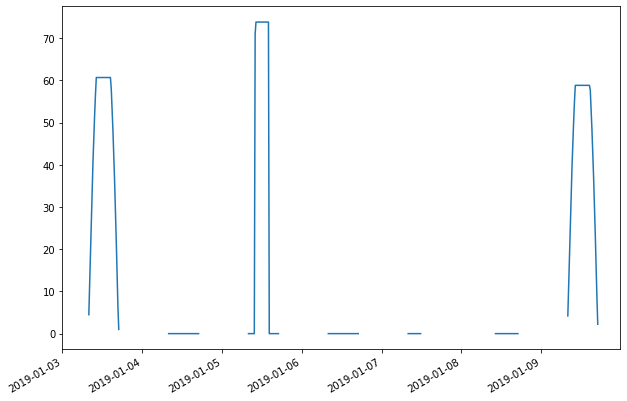

In [13]:
estimated_full_power = meter / online_fraction
lost_power = estimated_full_power - meter
lost_power = lost_power.clip(lower=0)
lost_power.plot()

Because this method depends on scaling the meter data by online capacity, it assumes that at least part of the system is producing.  Power loss when the entire system is offline must be calculated some other way, since there's no way to use the meter data as a reference.

There are two possibilities here.  The first is to use site-measured weather data and a performance model to predict system power output.  The second is to use a seasonal daily production profile.  The seasonal profile can be calculated from historical production data or an 8760.  

Using weather-predicted power is preferred since it takes true weather into account, but using the seasonal profiles is more flexible since it will work even when the entire system (including the weather stations) are offline.

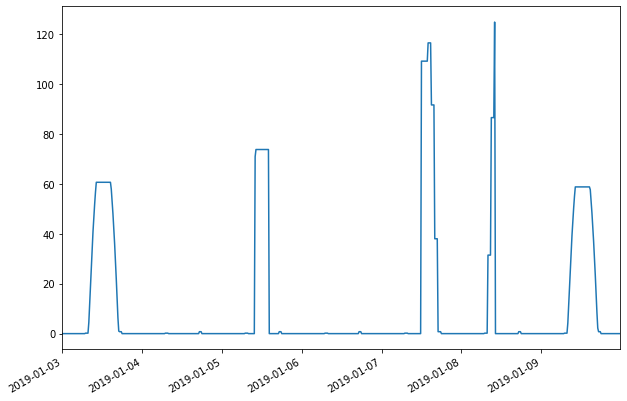

In [14]:
def signal_to_profile(signal):
    """Convert a timeseries to a 12x24"""
    aux = pd.DataFrame({'value': signal})
    aux['Hour'] = aux.index.hour
    aux['Month'] = aux.index.month
    profile = aux.pivot_table(values='value', index='Hour', columns='Month')
    return profile

def profile_to_signal(profile, times):
    """Convert a 12x24 to a timeseries"""
    aux = pd.DataFrame(index=times)
    aux['Hour'] = aux.index.hour
    aux['Month'] = aux.index.month

    profile = profile.copy()
    months = profile.columns
    profile['Hour'] = profile.index
    profile = profile.melt(id_vars=['Hour'], value_vars=months)
    profile['Month'] = profile['Month'].astype(int)

    signal = pd.merge(aux, profile, on=['Month', 'Hour'], how='left')
    signal.index = times
    return signal['value']


expected_power = np.nan * meter # pretend the entire system is offline
production_profile = signal_to_profile(meter) # ideally we would filter out downtime here

# for the case where all inverters are offline, we fall back to using
# site expected power (based on met data) or, if met data isn't
# available either, fall back to the TMY monthly production profile.
typical_power = profile_to_signal(production_profile, meter.index)
replacement_power = np.where(expected_power > 0,
                             expected_power,
                             typical_power)

# hourly TMY profile is broadcasted to subhourly values, so need to ignore
# times where the subhourly values don't count as daytime
lost_power[online_fraction == 0] = replacement_power
lost_power.plot()

Last, we apply two final corrections.  The first is to prevent spurious production loss around sunrise and sunset that can arise from inconsistency in power measurements as well as from broadcasting hourly 12x24 values into subhourly measurements.  The second is to prevent the estimated lost production from violating consistency with system power limitations.  

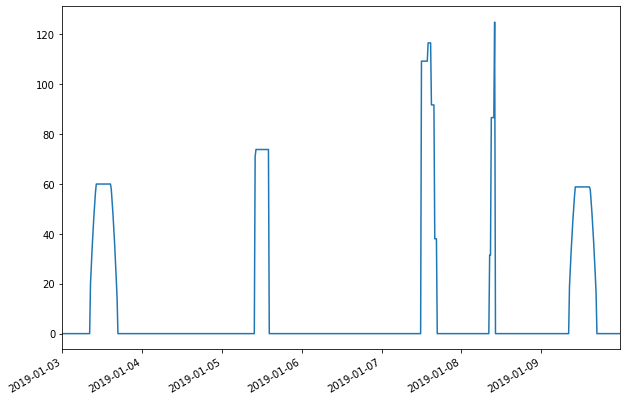

In [15]:
# example daylight calculation.  could also be done with eg GHI>50 W/m2, time of day, etc
loc = pvlib.location.Location(lat, lon)
solpos = loc.get_solarposition(meter.index)
is_daylight = solpos['elevation'] > 5 # degrees

lost_power.loc[~is_daylight] = 0

# system_limit is the max system output, whether it's total inverter AC nameplate, PPA limit, whatever
system_limit = 160
total_power = meter + lost_power
total_power_clipped = total_power.clip(upper=system_limit)
lost_power = total_power_clipped - meter
lost_power = lost_power.clip(lower=0, upper=system_limit)

lost_power.plot()

Now let's plot the results.  Note that the seasonal production profile in this toy example is using only a week's worth of data and it's full of downtime, so it'll look a little funny.

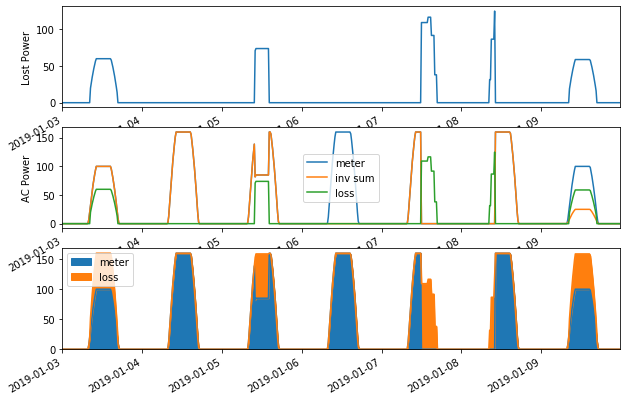

In [16]:
fig, ax = plt.subplots(3, 1)
lost_power.plot(ax=ax[0])
ax[0].set_ylabel('Lost Power')

df = pd.DataFrame({
    'meter': meter,
    'inv sum': inverter_power.sum(axis=1),
    'loss': lost_power
})
df.plot(ax=ax[1])
ax[1].set_ylabel('AC Power')

df[['meter', 'loss']].plot.area(ax=ax[2])


## Availability calculation

In [17]:
df_ava = pd.DataFrame({
    'Actual Energy': meter,
    'Lost Energy': lost_power
})
# in this simple case, assume (meter + ava_loss = P50)
df_ava['Expected Energy'] = df_ava['Actual Energy'] + df_ava['Lost Energy']

df_ava = df_ava.resample('d').sum()
df_ava['Availability'] = 1 - df_ava['Lost Energy'] / df_ava['Expected Energy']
print(df_ava)

                           Actual Energy   Lost Energy  Expected Energy  \
2019-01-03 00:00:00-05:00    2796.869549  1.660978e+03      4457.847068   
2019-01-04 00:00:00-05:00    4506.288541  2.629008e-13      4506.288541   
2019-01-05 00:00:00-05:00    3243.184635  1.252529e+03      4495.713633   
2019-01-06 00:00:00-05:00    4520.801763  0.000000e+00      4520.801763   
2019-01-07 00:00:00-05:00    1903.694738  1.821771e+03      3725.465654   
2019-01-08 00:00:00-05:00    3754.473388  5.345191e+02      4288.992452   
2019-01-09 00:00:00-05:00    2827.121270  1.637100e+03      4464.221207   

                           Availability  
2019-01-03 00:00:00-05:00      0.627404  
2019-01-04 00:00:00-05:00      1.000000  
2019-01-05 00:00:00-05:00      0.721395  
2019-01-06 00:00:00-05:00      1.000000  
2019-01-07 00:00:00-05:00      0.510995  
2019-01-08 00:00:00-05:00      0.875374  
2019-01-09 00:00:00-05:00      0.633284  
